In [ ]:
# Basic dependencies

import os 
import os.path
import io 
import traceback
from absl import app
from absl import flags

import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import yaml
from PIL import Image
from easydict import EasyDict as edict

os.environ['OPENAI_API_KEY'] = "sk-proj-/-NokGDdVyTJTx6CFKJy6yQtwmqHBwNdUYjJyWou2mjWagQRV0C2gEPlyJFqXEtmI6ZSp8sXi9CT3BlbkFJr9ZI4ck02lQLW0TL6MOIDCOzBA2yZS-MAS_onNDAun97YIepLWHJThnLMQrWQ_ISIQKHt9ix4A" # put your key here

In [122]:
# MOKA utilities

from string import ascii_lowercase

from openai import OpenAI
client = OpenAI()

from moka.gpt_utils import request_gpt
from moka.vision.segmentation import get_scene_object_bboxes
from moka.vision.segmentation import get_segmentation_masks
from moka.vision.keypoint import get_keypoints_from_segmentation
from moka.planners.planner import Planner
from moka.planners.visual_prompt_utils import *

In [123]:
import os
config_filename = './config/moka.yaml'
with open(config_filename, 'r') as fh:
    config = yaml.load(fh, Loader=yaml.SafeLoader)
    config = edict(config)

In [124]:
def load_prompts():
    """Load prompts from files.
    """
    prompts = dict()
    prompt_dir = os.path.join(
        config.prompt_root_dir, config.prompt_name)
    for filename in os.listdir(prompt_dir):
        path = os.path.join(prompt_dir, filename)
        if os.path.isfile(path) and path[-4:] == '.txt':
            with open(path, 'r') as f:
                value = f.read()
            key = filename[:-4]
            prompts[key] = value
    return prompts
    
prompts = load_prompts()

In [125]:
# obs_image = Image.open('example/obs_image.jpg').convert('RGB')
# obs_image = Image.open('example/bookshelf_top.png').convert('RGB')
# obs_image = Image.open('example/edge_top.png').convert('RGB')
# obs_image = Image.open('example/wall_top.png').convert('RGB')
# obs_image = Image.open('example/slope_top.png').convert('RGB')
# obs_image = Image.open('example/slot_top.png').convert('RGB')
# obs_image = Image.open('example/tool1_top.jpeg').convert('RGB')
# obs_image = Image.open('example/tool2_top.jpeg').convert('RGB')
# obs_image = obs_image.resize([512, 512], Image.LANCZOS)

# obs = {'image': obs_image}
# plt.imshow(obs_image)
# plt.axis('off')
# plt.show()

# task_instruction = 'Use the white ultrasound cleaner to clean the metal watch. The unstrasound cleaner has no lid and can be turned on by pressing the red button.'
# task_instruction = 'Align the red cracker box with the grey virtual cracker box.'
# task_instruction = 'Align the book on the shelf with the grey virtual square.'
# task_instruction = 'Align the black keyboard with the grey virtual keyboard.'
# task_instruction = 'Move the black keyboard to accross the wooden wall.'
# task_instruction = 'Move the brown chocolate to accross the red slope, reach the grey virtual square.'
# task_instruction = 'Move the brown chocolate to accross the blank slot, reach the grey virtual square.'
# task_instruction = 'Use the blue tool to pull the red cube to yellow square region.'
# task_instruction = 'Use the blue tool to push the red cube to the grey virtual square.'
# print('Task: ', task_instruction)

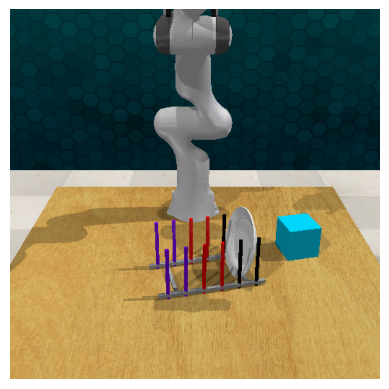

Task:  Take the plate off the colored dish rack.


In [126]:
# obs_image = Image.open('rlbench/CloseBox.jpg').convert('RGB')
# obs_image = Image.open('rlbench/OpenWineBottle.jpg').convert('RGB')
# obs_image = Image.open('rlbench/PickUpCup.jpg').convert('RGB')
# obs_image = Image.open('rlbench/PlugChargerInPowerSupply.jpg').convert('RGB') 
# obs_image = Image.open('rlbench/SlideCabinetOpenAndPlaceCups.png').convert('RGB')
# obs_image = Image.open('rlbench/TakeFrameOffHanger.png').convert('RGB')
# obs_image = Image.open('rlbench/PutShoesInBox.jpeg').convert('RGB')
obs_image = Image.open('rlbench/TakePlateOffColoredDishRack.png').convert('RGB')
obs_image = obs_image.resize([512, 512], Image.LANCZOS)

obs = {'image': obs_image}
plt.imshow(obs_image)
plt.axis('off')
plt.show()

# task_instruction = 'Close the box.'
# task_instruction = 'Open the wine bottle by grabbing the cap.'
# task_instruction = 'Pick up the red cup.'
# task_instruction = 'Plug the charger into the power supply.'
# task_instruction = 'Slide the cabinet open and place the cup into the cabinet.'
# task_instruction = 'Take the frame off the hanger.'
# task_instruction = 'Put the right shoe in the box.'
task_instruction = 'Take the plate off the colored dish rack.'

print('Task: ', task_instruction)


In [127]:
plan = request_plan(
    task_instruction,
    obs_image, 
    plan_with_obs_image=config.plan_with_obs_image,
    prompts=prompts,
    debug=True)

# Example response after filtering

# res = """
# [
#     {
#         "instruction": "Move the metal watch into the ultrasound cleaner.",
#         "object_grasped": "metal watch",
#         "object_unattached": "white ultrasound cleaner",
#         "motion_direction": "downward"
#     },
#     {
#         "instruction": "Press the red button to turn on the ultrasound cleaner.",
#         "object_grasped": "",
#         "object_unattached": "red button",
#         "motion_direction": "downward"
#     }
# ]
# """

# object_info = json.loads(res)
# plan = object_info
print(plan)

--------------------------------
| Generated plan.
--------------------------------
```json
[
    {
        "instruction": "Grip the plate from the colored dish rack.",
        "object_grasped": "plate",
        "object_unattached": "",
        "motion_direction": ""
    },
    {
        "instruction": "Lift the plate upward to remove it from the rack.",
        "object_grasped": "plate",
        "object_unattached": "dish rack",
        "motion_direction": "upward"
    }
]
```
--------------------------------
| Filtered plan.
--------------------------------
```json
[
    {
        "instruction": "Lift the plate upward to remove it from the rack.",
        "object_grasped": "plate",
        "object_unattached": "dish rack",
        "motion_direction": "upward"
    }
]
```
[{'instruction': 'Lift the plate upward to remove it from the rack.', 'object_grasped': 'plate', 'object_unattached': 'dish rack', 'motion_direction': 'upward'}]


In [128]:
all_object_names = []
for subtask in plan:
    if subtask['object_grasped'] != '' and subtask['object_grasped'] not in all_object_names:
        all_object_names.append(subtask['object_grasped'])

    if subtask['object_unattached'] != '' and subtask['object_unattached'] not in all_object_names:
        all_object_names.append(subtask['object_unattached'])

print(all_object_names)

['plate', 'dish rack']


Loading GroundingDINO model from ./ckpts
./ckpts/groundingdino_swint_ogc.pth ; exist: True
final text_encoder_type: bert-base-uncased


/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ch

Model loaded successfully. Detecting objects for: ['plate', 'dish rack']


/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/groundingdino/models/GroundingDINO/transformer.py:862: F

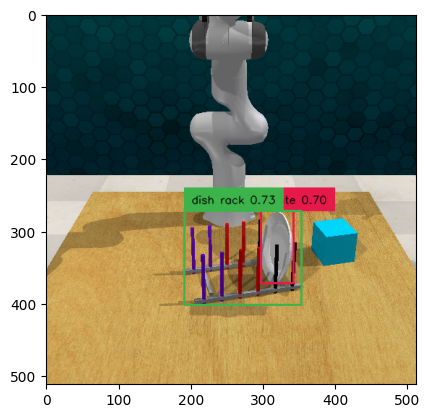

In [129]:
# get bounding boxes
boxes, logits, phrases = get_scene_object_bboxes(
                obs_image, all_object_names,
                visualize=True,
                logdir=None)

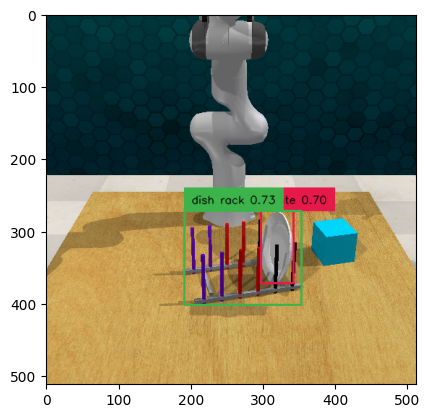

/home/nus/zjx/moka/grounded-sam/segment_anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


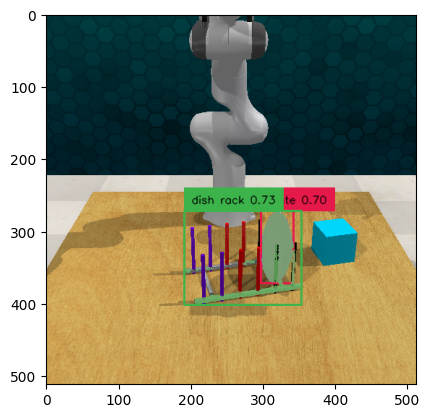

In [130]:
# Get segmentation masks
segmasks = get_segmentation_masks(obs_image, all_object_names, boxes, logits, phrases, visualize=True)

image_size (annotate_candidate_keypoints) (512, 512)


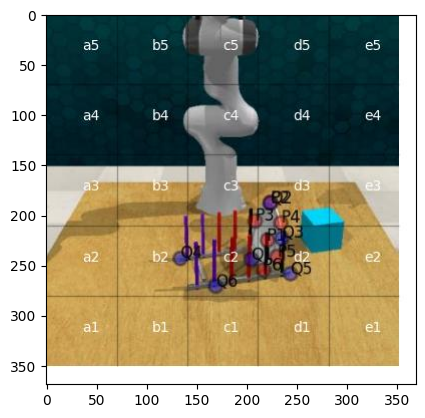

In [131]:
# Annotate visual marks.
subtask = plan[0]
candidate_keypoints = propose_candidate_keypoints(
    subtask,
    segmasks, 
    num_samples=config.num_candidate_keypoints)

annotation_size = next(iter(segmasks.values()))['mask'].shape[:2][::-1] 
obs_image_reshaped = obs_image.resize(annotation_size, Image.LANCZOS)

annotated_image = annotate_visual_prompts(
            obs_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size)

--------------------------------
| Selected motion.
--------------------------------
To solve the task of lifting the plate upward to remove it from the rack, we need to determine the appropriate keypoints and waypoints as per the instruction and provided image.

1. **Grasp Keypoint:**
   - **Choice:** P[3] 
   - **Reason:** The grasping point should be selected to securely hold the plate. P[3] is centrally located on the plate, ensuring a stable grasp.

2. **Function Keypoint:**
   - **Choice:** P[3]
   - **Reason:** For the lifting motion, the functional point is the same as the grasping point since we're performing a lifting action.

3. **Target Keypoint:**
   - **Choice:** Q[3]
   - **Reason:** Q[3] is the point on the dish rack where the plate is aligned. It's essential to ensure that the plate is removed from this point.

4. **Target Tile:**
   - **Choice:** c3
   - **Reason:** The target keypoint Q[3] is located in tile c3.

5. **Pre-Contact Tile:**
   - **Choice:** c3
   - **Re

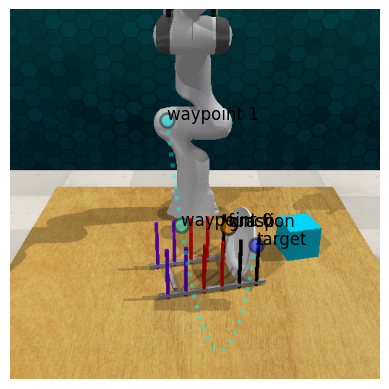

In [132]:
# Select motion 
# The json format given by GPT4-O can be incorrect. If it fails to visualize the image, please check whether the context is correctly parsed 

from moka.planners.visual_prompt_utils import request_motion

context, _, _ = request_motion(
            subtask,
            obs_image,
            annotated_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size, 
            prompts=prompts, 
            debug=True
    )